# Project Milestone 2 Notebook
## Evolution of beer preferences between 2000 and 2017.
## Have beer style preferences evolved similarly across different cultures and countries?
### Sub Questions:
- Have Americans faced the same preference evolution as Europeans?
- How have sensory attributes (appearance, aroma, palate) of beers influenced user ratings and preferences over time?
- Can we see an evolution linked to the ABV?
- What are the major trends in beer preferences over the last 17 years?

## 0. Imports and global variables

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from load_data import load_data

## 2. How have sensory attributes (appearance, aroma, palate) of beers influenced user ratings and preferences over time?
Load the relevant data:

In [106]:
# TODO: Add BeerAdvocate and remove max_entries + Discuss loading of data
df = load_data("./data/RateBeer/ratings.txt.gz", ["date", "appearance", "aroma", "palate", "taste", "overall", "rating"], max_entries=100000)

Loading data from:  ./data/RateBeer/ratings.txt.gz


1699997it [00:02, 826313.36it/s]


In [107]:
df = df.astype({'appearance': 'int8',
                'aroma': 'int8',
                'palate': 'int8',
                'taste': 'int8',
                'overall': 'int8',
                'rating': 'float32'})
# TODO: Discuss monthly vs yearly + Other ideas
df['date'] = pd.to_datetime(df['date'].astype('int64'), unit='s').dt.to_period('m').astype('datetime64[M]')
df = df.sort_values(by='date')

In [108]:
print(df.dtypes)

date          datetime64[ns]
appearance              int8
aroma                   int8
palate                  int8
taste                   int8
overall                 int8
rating               float32
dtype: object


In [109]:
print(df)

            date  appearance  aroma  palate  taste  overall  rating
58196 2000-05-01           3      6       3      6       12     3.0
14220 2000-05-01           2      1       1      1        2     0.7
53134 2000-05-01           3      2       2      5       10     2.2
42558 2000-05-01           2      4       3      6       13     2.8
53132 2000-06-01           2      1       2      2        2     0.9
...          ...         ...    ...     ...    ...      ...     ...
2288  2017-07-01           4      6       5      8       16     3.9
27077 2017-07-01           3      6       2      6       14     3.1
17161 2017-07-01           3      5       3      5       11     2.7
91766 2017-07-01           4      6       4      7       14     3.5
68464 2017-07-01           3      4       3      4       10     2.4

[100000 rows x 7 columns]


<Axes: xlabel='date', ylabel='appearance'>

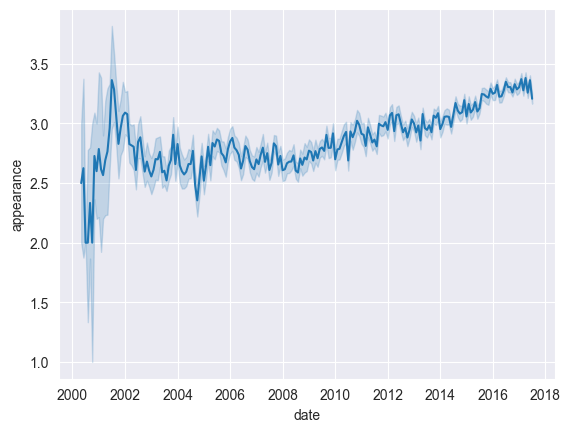

In [110]:
sns.lineplot(data=df, x='date', y='appearance')

<Axes: xlabel='date', ylabel='aroma'>

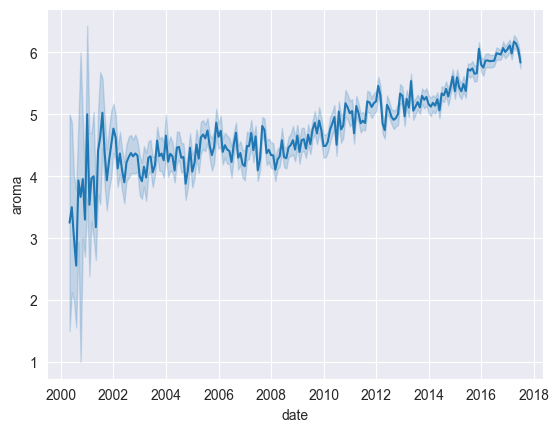

In [111]:
sns.lineplot(data=df, x='date', y='aroma')

<Axes: xlabel='date', ylabel='palate'>

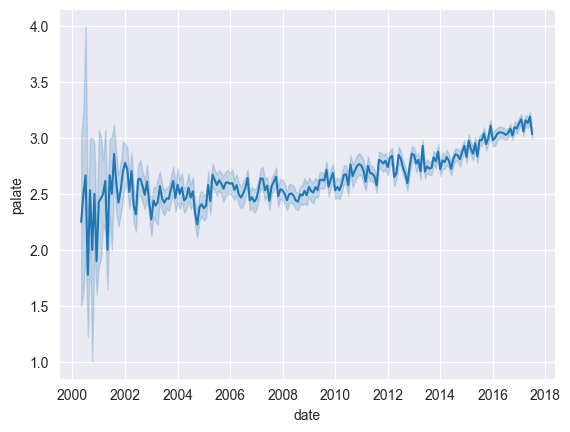

In [112]:
sns.lineplot(data=df, x='date', y='palate')

<Axes: xlabel='date', ylabel='taste'>

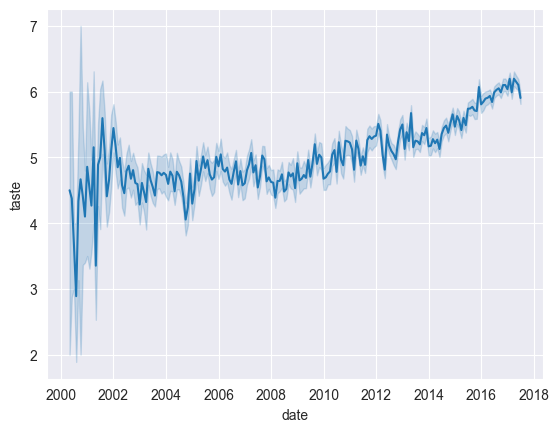

In [113]:
sns.lineplot(data=df, x='date', y='taste')

<Axes: xlabel='date', ylabel='overall'>

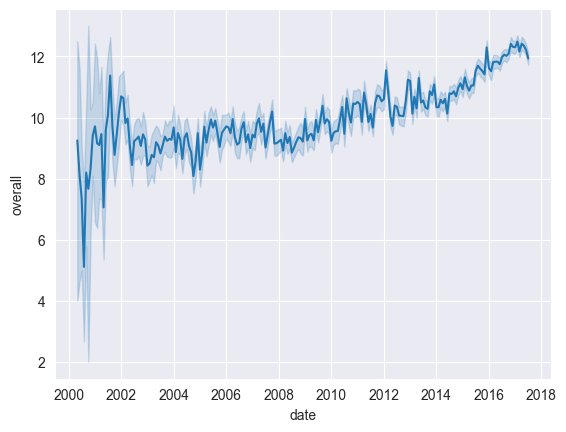

In [114]:
sns.lineplot(data=df, x='date', y='overall')

<Axes: xlabel='date', ylabel='rating'>

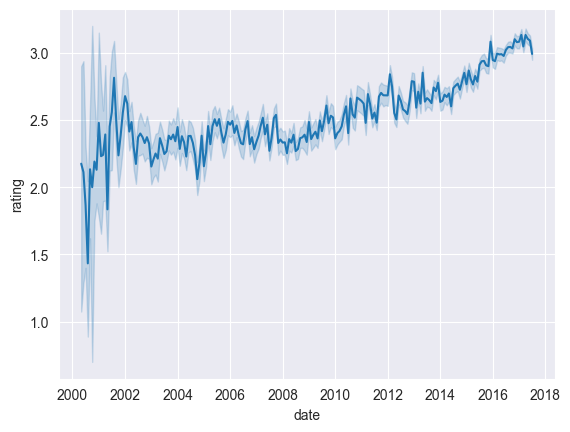

In [115]:
sns.lineplot(data=df, x='date', y='rating')